In [1]:
import os
os.environ["CC"] = "gcc"
os.environ["CXX"] = "gcc"
import sys
sys.path.append('/usr/lib/python3/dist-packages')
print(sys.path)
import os
os.environ["OMP_PROC_BIND"] = os.environ.get("OMP_PROC_BIND", "true")

import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
%matplotlib inline

from pix_transform.pix_transform import PixTransform
from baselines.baselines import bicubic
from utils.utils import downsample,align_images
from prox_tv import tvgen
from utils.plots import plot_result
import imageio
import torch


import time
from PIL import Image
import scipy.signal

['/home/beast2020/Desktop/mingchi/PixTransform-save_params', '/home/beast2020/anaconda3/lib/python38.zip', '/home/beast2020/anaconda3/lib/python3.8', '/home/beast2020/anaconda3/lib/python3.8/lib-dynload', '', '/home/beast2020/.local/lib/python3.8/site-packages', '/home/beast2020/anaconda3/lib/python3.8/site-packages', '/home/beast2020/.local/lib/python3.8/site-packages/IPython/extensions', '/home/beast2020/.ipython', '/usr/lib/python3/dist-packages']


In [2]:
def downsample(ar,factor):
    kernel = np.full((factor,factor),1/(factor**2))
    ar = scipy.signal.convolve2d(np.asarray(ar),kernel,mode='full')
    ar = ar[factor-1::factor,factor-1::factor]
    return ar
                 

## Fine plotting , x8, EPFL_nadir, 1 image, 60

In [6]:
# load 1 oblique image for test of hyperparameter
# EPFL-2020-09-17-planned_00292_100_0039_0060
_rgb_files = '/home/beast2020/Desktop/mingchi/EPFL_10_newsample_nadir/rgb/EPFL-2020-09-17-planned_00292_100_0039_0060.png'
_dist_files = '/home/beast2020/Desktop/mingchi/EPFL_10_newsample_nadir/dist/EPFL-2020-09-17-planned_00292_100_0039_0060.dat'
_pred_files = '/home/beast2020/Desktop/mingchi/PMBANet_TOPO/Results/EPFL_nadir/distpng/17.png'


guide_imgs = []
target_imgs= []
rgb_img = imageio.imread(_rgb_files)
guide_imgs = rgb_img
dist_img = torch.load(_dist_files)
dist_img = dist_img.detach().cpu().numpy()
target_imgs = dist_img
source_imgs = downsample(dist_img,8)
predict= imageio.imread(_pred_files)
recover_imgs =predict[:480,:720] 

        
guide_imgs = np.asarray(guide_imgs)      
target_imgs = np.asarray(target_imgs)
source_imgs = np.asarray(source_imgs)
predict_imgs = np.asarray(recover_imgs)
error_imgs = predict_imgs/255 * np.max(target_imgs) - target_imgs

print('Guide: ')
print(guide_imgs.shape)
print('Target: ')
print(target_imgs.shape)
print('Source: ')
print(source_imgs.shape)
print('Predict: ')
print(predict_imgs.shape)
print('Error: ')
print(error_imgs.shape)

Guide: 
(480, 720, 3)
Target: 
(480, 720)
Source: 
(60, 90)
Predict: 
(480, 720)
Error: 
(480, 720)


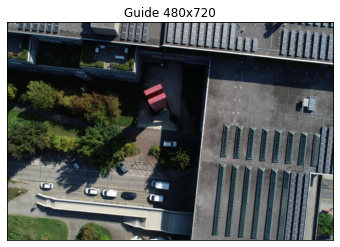

In [8]:

plt.imshow(guide_imgs)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
plt.title('Guide 480x720')
plt.savefig('PMBA_plots/PMBA_G_60.png',bbox_inches='tight')

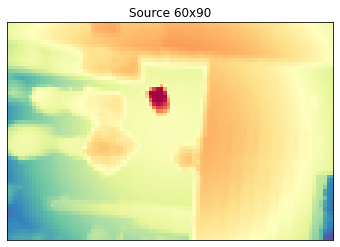

In [9]:
#source image
vmin = np.min(target_imgs)
vmax = np.max(target_imgs)
cmap = 'Spectral'

plt.imshow(source_imgs,vmin = vmin,vmax = vmax,cmap=cmap)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
plt.title('Source 60x90')
plt.savefig('PMBA_plots/PMBA_S_60.png',bbox_inches='tight')

In [10]:
vmin

44.8024

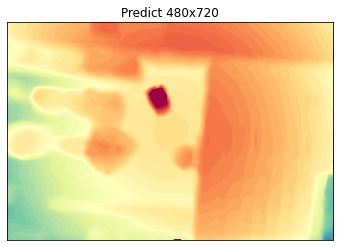

In [13]:
#predict

plt.imshow(predict_imgs/255 * np.max(target_imgs),vmin=vmin,vmax=vmax,cmap=cmap)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
plt.title('Predict 480x720')
plt.savefig('PMBA_plots/PMBA_P_60.png',bbox_inches='tight')

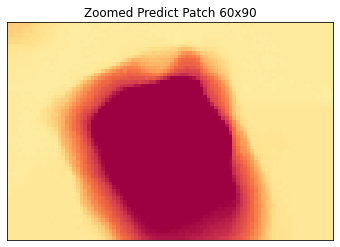

In [14]:
# zoom predict
temp = predict_imgs/255 * np.max(target_imgs)
plt.imshow(temp[130:190,290:380],vmin = vmin,vmax = vmax,cmap=cmap)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
plt.title('Zoomed Predict Patch 60x90')
plt.savefig('PMBA_plots/PMBA_ZP_60.png',bbox_inches='tight')

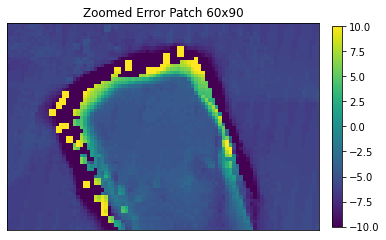

In [15]:
#error zoomed

error = plt.imshow(error_imgs[130:190,290:380],vmin = -10, vmax = 10,interpolation='none')
cbar1 = plt.colorbar(error,fraction=0.03,pad=0.04)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
plt.title('Zoomed Error Patch 60x90')
plt.savefig('PMBA_plots/PMBA_ZE_60.png',bbox_inches='tight')

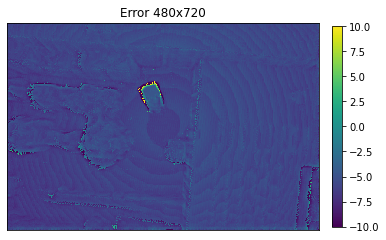

In [17]:
#error

error = plt.imshow(error_imgs,vmin = -10, vmax = 10,interpolation='none')
cbar1 = plt.colorbar(error,fraction=0.03,pad=0.04)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
plt.title('Error 480x720')
plt.savefig('PMBA_plots/PMBA_E_60.png',bbox_inches='tight')

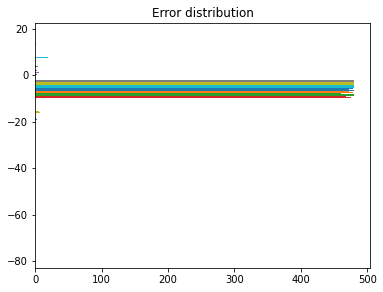

In [18]:
# error distribution
plt.figure(figsize=(4*1.5,3*1.5))
plt.hist(error_imgs,orientation='horizontal');
plt.title('Error distribution')
plt.savefig('PMBA_plots/PMBA_D_60.png',bbox_inches='tight')

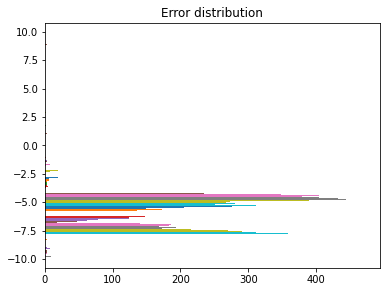

In [19]:
# bounded error distribution
plt.figure(figsize=(4*1.5,3*1.5))
plt.hist(error_imgs,orientation='horizontal',range=(-10,10));
plt.title('Error distribution')
plt.savefig('PMBA_plots/PMBA_Drange_60.png',bbox_inches='tight')

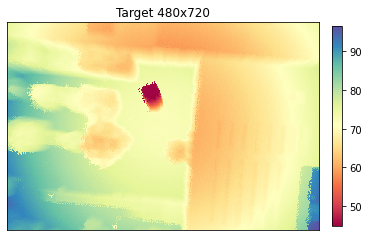

In [20]:
# target
target = plt.imshow(target_imgs,vmin = vmin, vmax = vmax,cmap = cmap,interpolation='none')
cbar1 = plt.colorbar(target,fraction=0.03,pad=0.04)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
plt.title('Target 480x720')
plt.savefig('PMBA_plots/PMBA_T_60.png',bbox_inches='tight')

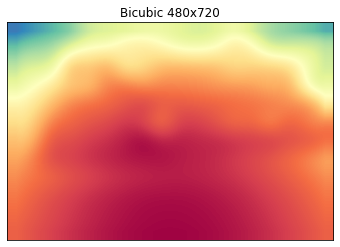

In [31]:
#Bicubic
plt.imshow(bicubic_target_img,vmin = vmin,vmax = vmax,cmap=cmap)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
plt.title('Bicubic 480x720')
# plt.savefig('B_334.png',bbox_inches='tight')